## Import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import pyplot, transforms
from matplotlib.patches import Rectangle
import seaborn as sns
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
parent_dir = Path.cwd().parent.parent.parent

"""
This code is used for Fig4.A-B.accessibility and equity across U.S. regions segmented by political affiliation. 
"""

'\nThis code is used for Fig4.A-B.accessibility and equity across U.S. regions segmented by political affiliation. \n'

## Data Processing

Data Source：Margin of victory in presidential elections  
https://usafacts.org/articles/how-red-or-blue-is-your-state/  
https://www.fec.gov/introduction-campaign-finance/election-results-and-voting-information/

In [2]:
def load_and_merge_us_map_data(geojson_path, parent_directory=None):
    """
    Load and merge US map geospatial data with political party information.
    """
    # Read US map GeoJSON file and select relevant columns
    gdf1 = gpd.read_file(geojson_path)
    gdf1 = gdf1[['GID_0', 'GID_1', 'GID_2', 'COUNTRY', 'NAME_1', 'NAME_2', 'geometry']]
    
    # Read political party data from Excel file
    excel_path = 'US_party_state_split.xlsx'
    data_party = pd.read_excel(excel_path)
    
    # Merge geospatial data with party information using GID_1 as the key
    # GID_1 typically represents state-level identifiers
    usa_map_gdf = pd.merge(
        gdf1, 
        data_party[['GID_1', 'Party']], 
        left_on='GID_1', 
        right_on='GID_1', 
        how='left'
    )
    
    return usa_map_gdf

In [3]:
def processing_acc_data(year, usa_map_gdf, parent_dir, type='population-based'):
    """
    Process EV charging station accessibility data for a given year.
    """
    # Load EV charging station data for specified year
    if type == 'population-based':
        acc_file = parent_dir / 'data' / 'US-accessibility' / 'population-based' / f'{year}' / f'{year}_city_accessibility_summaries_evse_count.csv'
    elif type == 'facility-based':
        acc_file = parent_dir / 'data' / 'US-accessibility' / 'facility-based' / f'{year}_poi_1km' / f'{year}_accessibility_summary_evse_num.csv'
    
    evse_data = pd.read_csv(acc_file)
    # Merge accessibility data with US map geometries using GID_2 identifier
    merged_gdf = pd.merge(
        usa_map_gdf, 
        evse_data[['GID_2', 'Average_Accessibility']], 
        on='GID_2', 
        how='inner'
    )

    return merged_gdf

In [4]:
def combine_accessibility_data(matched_gdf_2014, matched_gdf_2019, matched_gdf_2024):
    """
    Combine accessibility data from multiple years and calculate growth rates by political party.
    """
    
    # Combine DataFrames from three years and add Year identifier
    combined_df = pd.concat([
        matched_gdf_2014.assign(Year=2014),
        matched_gdf_2019.assign(Year=2019), 
        matched_gdf_2024.assign(Year=2024)
    ])
    
    # Reshape data from long to wide format - accessibility values as columns by year
    merged_df = combined_df.pivot(
        index='GID_2',          # Unique geographical identifier
        columns='Year',         # Year becomes column headers  
        values='Average_Accessibility'  # Accessibility values populate cells
    ).reset_index()
    
    # Rename columns for clarity
    merged_df.columns = ['GID_2', 'Accessibility_2014', 'Accessibility_2019', 'Accessibility_2024']
    
    # Merge political party information (assumed constant across years)
    party_info = matched_gdf_2014[['GID_2', 'Party']]
    merged_df = pd.merge(merged_df, party_info, on='GID_2')

    # Calculate percentage growth rate from 2014 to 2019
    # Handle division by zero by replacing with NaN, then fill with 0
    merged_df['Growth1'] = np.where(
        merged_df['Accessibility_2014'] != 0,
        ((merged_df['Accessibility_2019'] - merged_df['Accessibility_2014']) / merged_df['Accessibility_2014']) * 100,
        np.nan
    )

    # Calculate percentage growth rate from 2019 to 2024
    merged_df['Growth2'] = np.where(
        merged_df['Accessibility_2019'] != 0,
        ((merged_df['Accessibility_2024'] - merged_df['Accessibility_2019']) / merged_df['Accessibility_2019']) * 100,
        np.nan
    )
    
    # Replace NaN values with 0 for analysis
    merged_df = merged_df.fillna(0)
    
    # Calculate median growth rates grouped by political party
    median_growth_2014_2019 = merged_df.groupby('Party')['Growth1'].median()
    median_growth_2019_2024 = merged_df.groupby('Party')['Growth2'].median()
    
    return median_growth_2014_2019, median_growth_2019_2024

## Mapping and visualization

In [5]:
def merge_geometries_by_attribute(gdf, groupby_column='NAME_1', crs=4326):
    """
    Merge geometries in a GeoDataFrame by grouping them based on a specified attribute column.
    """
    # Dictionary to store merged geometries
    merged_geometries = {}
    
    # Group by specified column and merge geometries for each group
    for name, group in gdf.groupby(groupby_column):
        # Use unary_union to merge multiple polygons into one (if overlaps exist)
        # If only one geometry exists in group, use it directly
        if group['geometry'].size > 1:
            merged_geom = unary_union(group['geometry'].tolist())
        else:
            merged_geom = group['geometry'].iloc[0]
        merged_geometries[name] = merged_geom
    
    # Create new DataFrame to store merged results
    merged_df = pd.DataFrame.from_dict(merged_geometries, orient='index', columns=['geometry'])
    merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')
    
    # Add original grouping column as attribute column
    merged_gdf[groupby_column] = merged_gdf.index
    
    # Reset index to get clean sequential indexing
    merged_gdf.reset_index(drop=True, inplace=True)
    
    # Set Coordinate Reference System for the output GeoDataFrame
    merged_gdf_with_crs = merged_gdf.set_crs(epsg=crs)
    
    return merged_gdf_with_crs

In [6]:
def plot_us_party_map(merged_gdf_with_crs, usa_map_gdf, area='US', figsize=(10, 6), dpi=150):
    """
    Plot US political party affiliation map with optional regional focus.
    """
    
    # Define Coordinate Reference System (Albers Equal Area projection)
    albers_proj = '+proj=aea +lat_1=20 +lat_2=60 +lon_0=0'
    
    # Define font styles for map elements
    font1 = {'family': 'Arial', 
            'style': 'italic',
            'weight': 'normal', 
            'color': 'black',
            'size': 6
           }
    
    font2 = {'family': 'Arial',
            'weight': 'normal',
            'size': 6
           }
    
    font3 = {'family': 'fantasy',
            'weight': 'bold', 
            'color': 'teal'
           }
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Configure plot parameters
    plt.rcParams['legend.labelspacing'] = 0.8
    plt.rcParams['legend.title_fontsize'] = 8
    
    # Set up coordinate transformation for map rotation
    base = pyplot.gca().transData
    rot = transforms.Affine2D().rotate_deg(60)
    
    # Plot base map with merged geometries (outline only)
    ax = merged_gdf_with_crs.to_crs(albers_proj).plot(
        ax=ax,
        aspect='equal',
        facecolor='none', 
        edgecolor='black', 
        linewidth=0.2, 
        alpha=0.5,
        zorder=11,
        transform=rot+base
    )
    
    # Plot political party map with color coding
    ax = usa_map_gdf.to_crs(albers_proj).plot(
        ax=ax,
        column='Party',
        cmap=ListedColormap(['skyblue', 'thistle', 'salmon']),  # Custom colormap for three parties
        categorical=True,  # Treat as categorical data
        missing_kwds={
            "color": "lightgray",
            "edgecolor": "white",
            "hatch": "//",
            "label": "Missing data"
        },
        edgecolor='lightgray',
        linewidth=0.15,
        legend_kwds={
            'loc': 'lower right',
            'title': 'Party Affiliation',
            'shadow': False,
            'prop': font2
        },
        zorder=2,
        transform=rot+base
    )
    
    # Set map extent based on selected area
    if area == 'US':
        # Mainland United States
        ax.set_ylim(-3600000, 0)
        ax.set_xlim(-12800000, -7300000)
    elif area == 'AK':
        # Alaska
        ax.set_ylim(450000, 3000000)
        ax.set_xlim(-15800000, -12000000)
    elif area == 'HI':
        # Hawaii
        ax.set_ylim(-2500000, -1000000)
        ax.set_xlim(-17000000, -15500000)
    else:
        raise ValueError("Area must be 'US', 'AK', or 'HI'")
    
    # Remove axis frames and ticks
    ax.axis('off')
    
    return fig, ax

In [7]:
def plot_growth_with_arrows_and_boxplot(growth_data, combined_df, figsize=(8, 4), ylim=(-5, 160), ylim2=(-5, 2000),ylabel_name = r'$\bf{Pop.-based\ Acc.}$'):
    """
    Plot party growth rate comparison with arrows and boxplot
    """
    combined_df = combined_df.reset_index(drop=True)
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Define party background colors (RGBA format, transparency 0.1)
    party_bg_colors = {
        'Republican': (1.0, 0.4, 0.4, 0.1),    # Light red background
        'Democratic': (0.4, 0.4, 1.0, 0.1),    # Light blue background
        'Swing State': (0.8, 0.4, 1.0, 0.1)    # Light purple background
    }
    
    # ===== First Subplot: Growth Rate with Arrows =====
    growth_df = pd.DataFrame(growth_data)
    
    # Draw background colors for each party
    for i, party in enumerate(['Republican', 'Swing State', 'Democratic']):
        x_start = i - 0.5
        x_end = i + 0.5
        ax1.add_patch(Rectangle(
            (x_start, ylim[0]), width=x_end-x_start, height=ylim[1]-ylim[0],
            facecolor=party_bg_colors[party], edgecolor='none', zorder=-1
        ))
    
    # Plot growth rate points (white circles)
    sns.stripplot(
        data=growth_df.melt(id_vars='Party', var_name='Type', value_name='Rate'),
        x='Party',
        y='Rate',
        order=['Republican', 'Swing State', 'Democratic'],
        palette={'Republican': 'white', 'Swing State': 'white', 'Democratic': 'white'},
        size=8,
        edgecolor='black',
        linewidth=1,
        jitter=False,
        ax=ax1
    )
    
    # Add arrows connecting the two growth rates
    for i, party in enumerate(['Republican', 'Swing State', 'Democratic']):
        rate1 = growth_df[growth_df['Party'] == party]['Growth_Rate1'].values[0]
        rate2 = growth_df[growth_df['Party'] == party]['Growth_Rate2'].values[0]
        
        # Draw arrow
        ax1.annotate(
            '', xy=(i, rate2), xytext=(i, rate1),
            arrowprops=dict(
                arrowstyle='->', 
                color='green', 
                lw=2,
                shrinkA=0, shrinkB=0
            ),
            zorder=10
        )
        
        # Add labels
        ax1.text(i+0.05, rate1, f'{rate1:.2f}%', ha='left', va='center', fontsize=11)
        ax1.text(i+0.05, rate2, f'{rate2:.2f}%', ha='left', va='center', fontsize=11)
    
    # Add dashed lines to separate parties
    ax1.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.axvline(x=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Set axis properties
    ax1.set_ylim(ylim[0], ylim[1])
    ax1.set_ylabel(r'$\bf{Growth\ (\%)}$', fontsize=15)
    ax1.set_xticklabels(['Republican', 'Swing State', 'Democratic'], fontsize=10)
    ax1.set_xlabel('')
    ax1.set_xticks([])  # Hide x-axis ticks
    
    # ===== Second Subplot: Boxplot =====
    # Draw background colors for each party
    for i, party in enumerate(['Republican', 'Swing State', 'Democratic']):
        x_start = i - 0.5
        x_end = i + 0.5
        ax2.add_patch(Rectangle(
            (x_start, -5),  # Bottom-left coordinates (x,y)
            width=x_end-x_start,  # Width
            height=ylim2[1]-ylim2[0],  # Height (covers y-axis range)
            facecolor=party_bg_colors[party],
            edgecolor='none',
            zorder=-1  # Ensure it's in the background
        ))
    
    # Plot boxplot
    sns.boxplot(
        data=combined_df,
        x='Party',
        y='Average_Accessibility',
        hue='Year',
        palette={'2014': 'orangered', '2019': 'teal', '2024': 'dodgerblue'},
        width=0.5,
        dodge=True,
        gap=0.3,
        order=['Republican', 'Swing State', 'Democratic'],
        flierprops={
            'marker': 'o',
            'markerfacecolor': 'white',
            'markeredgecolor': 'white',
            'markersize': 1.5
        },
        medianprops={
            'color': 'Orange',
            'linewidth': 2,
            'linestyle': '--'
        },
        ax=ax2
    )
    
    # Add dashed lines to separate different parties
    ax2.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.axvline(x=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Set y-axis range
    ax2.set_ylim(ylim2[0], ylim2[1])
    
    # Adjust label styles
    ax2.set_xlabel(r'$\bf{Counties\ by\ Party}$', fontsize=15, labelpad=8)
    ax2.set_ylabel(ylabel_name, fontsize=15)
    ax2.set_xticklabels(
        ax2.get_xticklabels(),
        rotation=0,  # Rotation angle
        fontsize=10,  # Font size
        ha='center'   # Horizontal alignment
    )
    
    # Remove default legend
    ax2.legend_.remove()
    
    plt.tight_layout()
    return fig, (ax1, ax2)

## Test run - Map

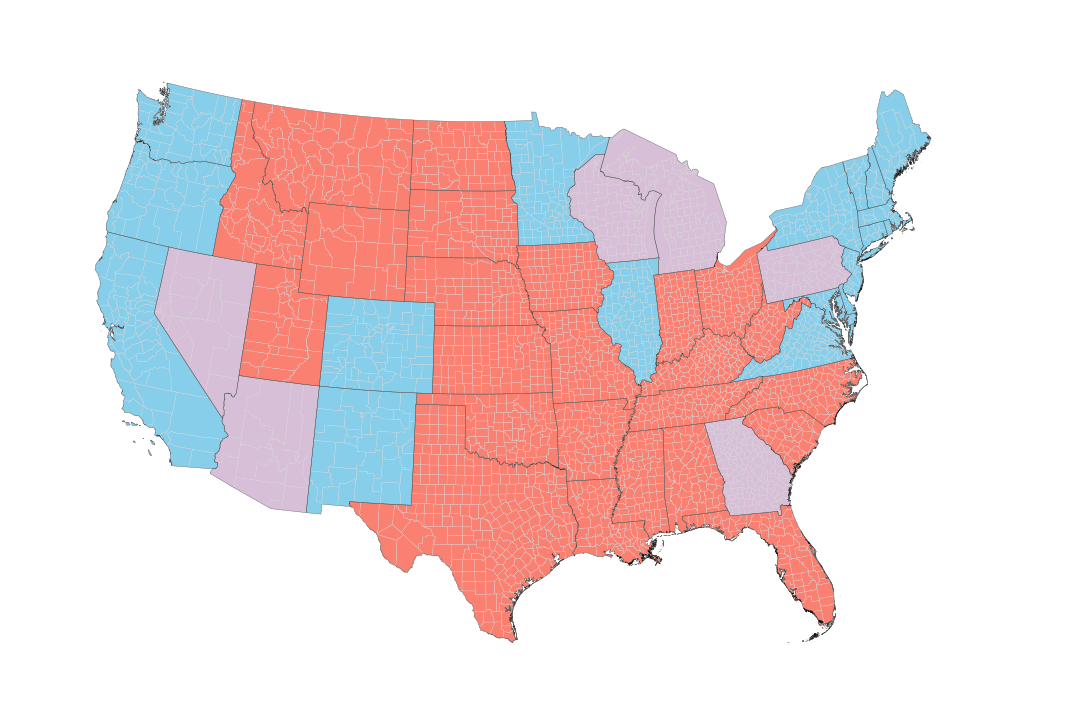

In [8]:
if __name__ == "__main__":

    # load data
    usa_map_gdf = load_and_merge_us_map_data (parent_dir / 'data' / 'US-map'/ 'usa_map.geojson')
    merged_gdf = merge_geometries_by_attribute(usa_map_gdf, 'NAME_1')
    
     # Plot mainland US political map
    fig_us, ax_us = plot_us_party_map(merged_gdf, usa_map_gdf, area='US')
    plt.show()
    
    # Plot Alaska political map
    #fig_ak, ax_ak = plot_us_party_map(merged_gdf, usa_map_gdf, area='AK')
    #plt.show()
    
    # Plot Hawaii political map
    #fig_hi, ax_hi = plot_us_party_map(merged_gdf, usa_map_gdf, area='HI')
    #plt.show()

## Test run - population-based acc.

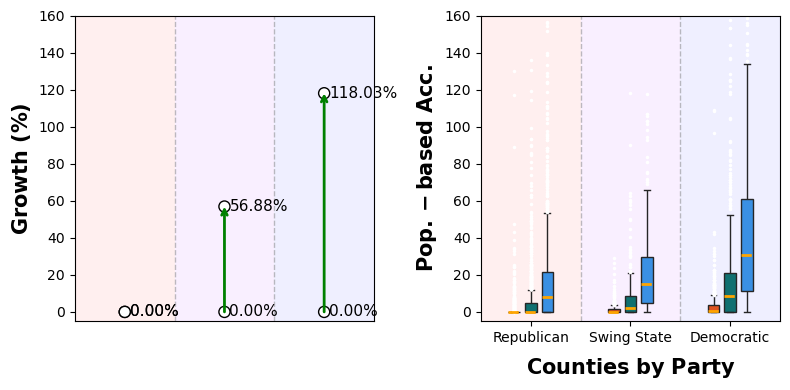

In [9]:
if __name__ == "__main__":

    # load data
    usa_map_gdf = load_and_merge_us_map_data (parent_dir / 'data' / 'US-map'/ 'usa_map.geojson')
    merged_gdf = merge_geometries_by_attribute(usa_map_gdf, 'NAME_1')

    # population-based
    pop_matched_gdf_2014 = processing_acc_data(2014, usa_map_gdf, parent_dir, type='population-based')
    pop_matched_gdf_2019 = processing_acc_data(2019, usa_map_gdf, parent_dir, type='population-based')
    pop_matched_gdf_2024 = processing_acc_data(2024, usa_map_gdf, parent_dir, type='population-based')
    
    pop_median_growth_2014_2019, pop_median_growth_2019_2024 = combine_accessibility_data(pop_matched_gdf_2014, pop_matched_gdf_2019, pop_matched_gdf_2024)
    pop_median_growth_2014_2019 = pop_median_growth_2014_2019.drop('Unknown', errors='ignore')
    pop_median_growth_2019_2024 = pop_median_growth_2019_2024.drop('Unknown', errors='ignore')
    # Prepare growth data
    growth_data = {
        'Party': ['Republican', 'Swing State', 'Democratic'],
        'Growth_Rate1': pop_median_growth_2014_2019.tolist()[::-1],  # Initial growth rate
        'Growth_Rate2': pop_median_growth_2019_2024.tolist()[::-1] # Final growth rate
    }
    
    # Prepare combined DataFrame (assuming you have the data)
    # Add Year column to each DataFrame
    pop_matched_gdf_2014['Year'] = '2014'
    pop_matched_gdf_2019['Year'] = '2019'
    pop_matched_gdf_2024['Year'] = '2024'
    
    # Merge DataFrames
    combined_df = pd.concat([pop_matched_gdf_2014, pop_matched_gdf_2019, pop_matched_gdf_2024])
    
    # Convert Party labels to Republican, Democratic, Swing State
    combined_df['Party'] = combined_df['Party'].replace({
        'red': 'Republican',
        'blue': 'Democratic',
        'purple': 'Swing State'
    })
    
    # Create the plot
    fig, (ax1, ax2) = plot_growth_with_arrows_and_boxplot(growth_data, combined_df,ylim=(-5, 160),ylim2=(-5, 160))
    plt.show()

## Test run - facility-based acc.

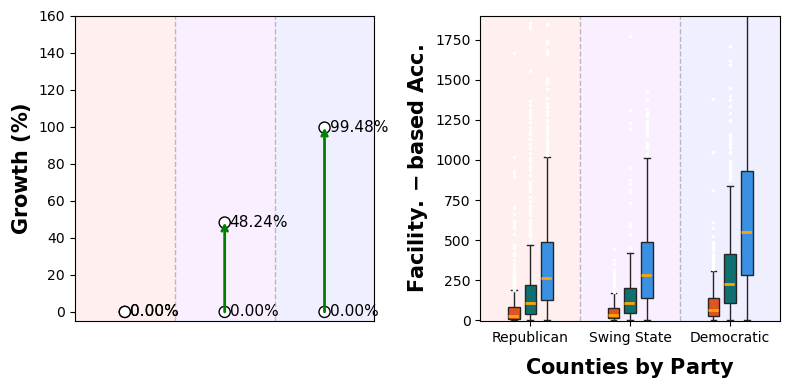

In [12]:
if __name__ == "__main__":

    # load data
    usa_map_gdf = load_and_merge_us_map_data (parent_dir / 'data' / 'US-map'/ 'usa_map.geojson')
    merged_gdf = merge_geometries_by_attribute(usa_map_gdf, 'NAME_1')

   # facility-based
    fac_matched_gdf_2014 = processing_acc_data(2014, usa_map_gdf, parent_dir, type='facility-based')
    fac_matched_gdf_2019 = processing_acc_data(2019, usa_map_gdf, parent_dir, type='facility-based')
    fac_matched_gdf_2024 = processing_acc_data(2024, usa_map_gdf, parent_dir, type='facility-based')
    
    fac_median_growth_2014_2019, fac_median_growth_2019_2024 = combine_accessibility_data(fac_matched_gdf_2014, fac_matched_gdf_2019, fac_matched_gdf_2024)
    
    # Prepare growth data
    growth_data = {
        'Party': ['Republican', 'Swing State', 'Democratic'],
        'Growth_Rate1': fac_median_growth_2014_2019.tolist()[::-1],  # Initial growth rate
        'Growth_Rate2': fac_median_growth_2019_2024.tolist()[::-1] # Final growth rate
    }
    
    # Prepare combined DataFrame (assuming you have the data)
    # Add Year column to each DataFrame
    fac_matched_gdf_2014['Year'] = '2014'
    fac_matched_gdf_2019['Year'] = '2019'
    fac_matched_gdf_2024['Year'] = '2024'
    
    # Merge DataFrames
    combined_df = pd.concat([fac_matched_gdf_2014, fac_matched_gdf_2019, fac_matched_gdf_2024])
    
    # Convert Party labels to Republican, Democratic, Swing State
    combined_df['Party'] = combined_df['Party'].replace({
        'red': 'Republican',
        'blue': 'Democratic',
        'purple': 'Swing State'
    })
    
    # Create the plot
    fig, (ax1, ax2) = plot_growth_with_arrows_and_boxplot(growth_data, combined_df, ylim=(-5, 160),ylim2=(-5, 1900),ylabel_name = r'$\bf{Facility.-based\ Acc.}$')
    plt.show()